In [ ]:
# save files
fullproc_r = './resources/' # for words/names

# where to save the figures that are created
fake_figs_dir = './example_lines/' # saving in github only for small numbers
# stop overwriting what is there
#fake_figs_dir = '/Users/jnaiman/Downloads/tmp/JCDL2025/example_lines/'

# format for saving images?
img_format = ['jpeg']

# save diagnostic plot with all items labeled?
save_diagnostic_plot = True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import pickle
import pandas as pd
#import string
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import ImageColor
import json
import os
from copy import deepcopy
import copy

from utils.metric_utils.utilities import isRectangleOverlap

import time

import matplotlib as mpl
import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}' #for \text command

# written libs -- will update locally
from utils.synthetic_fig_utils import subset_by_percent, \
 get_nrows_and_ncols, normalize_params_prob, get_ticks, get_titles_or_labels, \
 get_font_info

from utils.plot_utils import get_contour_plot, get_histogram_plot, \
   get_line_plot, get_scatter_plot, make_plot, colorbar_mods#, get_line_plot

from utils.text_utils import get_popular_nouns, get_inline_math

# create a bunch of fake figures
from utils.synthetic_fig_utils import normalize_params_prob
from utils.plot_parameters import plot_types_params, panel_params, \
  title_params, xlabel_params, colorbar_params, \
  ylabel_params, aspect_fig_params, dpi_params, tight_layout_params, \
  fontsizes, base

from utils.data_utils import get_data, NumpyEncoder
import numpy as np

import utils.distribution_utils

from utils.plot_utils import markers
marker_sizes = np.arange(0,10)+1
line_list_thick = np.arange(1,10)

use_uniques = True # use unique inlines
verbose = True

from sys import path
path.append('/Library/TeX/texbin/')

# debug
from importlib import reload

# for seed
from sys import maxsize as maxint

import warnings
warnings.filterwarnings("error")

In [3]:
# check directories
img_dir = fake_figs_dir + '/imgs/'
if not os.path.exists(img_dir):
    os.mkdir(img_dir)
    print('made:', img_dir)
json_dir = fake_figs_dir + '/jsons/'
if not os.path.exists(json_dir):
    os.mkdir(json_dir)
    print('made:', json_dir)

In [4]:
# get fonts -- see "cnn_create_synthetic_ticks" in FullProcess
dfont = pd.read_csv(fullproc_r + 'fonts.csv')

# check that location is there
drop_names = []
for fl in dfont['font location']:
    if not os.path.exists(fl):
        drop_names.append(False)
    else:
        drop_names.append(True)

font_names = dfont.loc[drop_names]['font name'].values

# # for plot styles
# plot_styles = plt.style.available

# plot_types_qa = ['line', 'scatter', 'histogram']

plot_styles = ['default']

In [5]:
# stats for doing calculations
stats = {'minimum':np.min, 'maximum':np.max, 'median':np.median, 'mean':np.mean}

# some things to try
aspect_cut = {'min':0.3, 'max':4.0}

In [6]:
# get popular words for titles/axis
popular_nouns = get_popular_nouns(fullproc_r + 'data/')

# get inline math formulas
inlines = get_inline_math(fullproc_r,
                          recreate_inlines=False,
                         use_uniques=use_uniques)

16253 343492
shape of output= (5097, 5)
shape of output= (36332, 5)
number of inlines =  33201


## Update plotting params

### Plot type params

In [7]:
plot_params = plot_types_params.copy()

In [8]:
# only histograms for this one

# probability of getting a scatter plot
plot_params['scatter']['prob'] = 0
# probability of getting a line
plot_params['line']['prob'] = 0
# prob of getting a contour plot
plot_params['contour']['prob'] = 0

In [9]:
# prob for getting a histogram
plot_params['histogram']['prob'] = 1


linestyles_hist = ['-'] # only use a subset of the linestyles

plot_params['histogram'] = plot_params['histogram'].copy()

# no horizontal plots
plot_params['histogram']['horizontal prob'] = 0.0

# random distributions
plot_params['histogram']['distribution']['random']['prob'] = 0

# gaussian mixture model
plot_params['histogram']['distribution']['gmm']['prob'] = 1
plot_params['histogram']['distribution']['gmm']['nclusters'] = {'min': 1, 'max': 5}
plot_params['histogram']['distribution']['gmm']['nsamples'] = {'min': 10, 'max': 50}

# linear distributions prob
plot_params['histogram']['distribution']['linear']['prob'] = 1

### Other parameters

In [10]:
panel_params['number prob']['median'] = 4 # smaller, usually use 4-ish, 1 for debugging
panel_params['number prob']['max'] = 25 # 2 for debugging, 25 for typical run

In [11]:
# for ease of things, lets not do equations here
title_params['equation']['prob'] = 0.0 # probability any word will be equation
xlabel_params['equation']['prob'] = 0.0 # probability any word will be equation
ylabel_params['equation']['prob'] = 0.0 # probability any word will be equation

Renormalize all probabilities:

In [12]:
# reload for debug
import utils.synthetic_fig_utils
reload(utils)
reload(utils.synthetic_fig_utils)
from utils.synthetic_fig_utils import normalize_params_prob

plot_params_out, panel_params, \
  title_params, xlabel_params, \
  ylabel_params = normalize_params_prob(plot_params.copy(), panel_params, 
                                        title_params, xlabel_params, 
                                        ylabel_params, colorbar_params)

plot_params_out

title_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
xlabel_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
ylabel_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
colorbar_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
plot_types_params['scatter']['color bar']['location probs'] did not add to 1! total = 0.8500000000000001
renormalizing...
now:  {'right': 0.588235294117647, 'left': 0.058823529411764705, 'top': 0.2941176470588235, 'bottom': 0.058823529411764705}
plot_types_params['contour']['color b

{'line': {'prob': 0,
  'npoints': {'min': 10, 'max': 11},
  'line thick': {'min': 1, 'max': 5},
  'nlines': {'min': 2, 'max': 3},
  'xmin': -10000,
  'xmax': 10000,
  'ymin': -10000,
  'ymax': 10000,
  'prob same x': 0.1,
  'markers': {'prob': 0.5, 'size': {'min': 1, 'max': 20}},
  'error bars': {'elinewidth': {'min': 1, 'max': 5},
   'x': {'prob': 0.25, 'size': {'min': 0.01, 'max': 0.1}},
   'y': {'prob': 0.25, 'size': {'min': 0.01, 'max': 0.1}}},
  'distribution': {'random': {'prob': 0.3333333333333333},
   'linear': {'prob': 0.3333333333333333,
    'intersect': (-100, 100),
    'slope': (-5, 5),
    'noise': (0, 0.25)},
   'gmm': {'prob': 0.3333333333333333,
    'histogram as line': {'prob': 0.25, 'factor': 1000},
    'nclusters': {'min': 1, 'max': 20},
    'nsamples': {'min': 10, 'max': 500},
    'cluster std': {'min': -2, 'max': 0.5},
    'noise': {'min': 0.05, 'max': 0.25}}}},
 'histogram': {'prob': 1,
  'npoints': {'min': 10, 'max': 10000},
  'nbins': {'min': 1, 'max': 100},
  '

### Run the thing

In [13]:
# Set a seed if you want a reproducible thing
seed_outer = np.random.randint(maxint)
#seed_outer = 7526304181034464103
seed_outer = 6700012876856450103

print('seed_outer =',seed_outer)
rng_outer = np.random.default_rng(seed_outer)

seed_outer = 6700012876856450103


In [14]:
# "Inner" seed -- for things like distributions and whatnot
seed = np.random.randint(maxint)
#seed = 2870146871786070273
seed = 7067533564274193147
print('seed = ', seed)
# based on seed, make random number generator, see: https://numpy.org/doc/2.2/reference/random/generator.html
rng = np.random.default_rng(seed)
condition_overlap_xticklabels = True

seed =  7067533564274193147


In [15]:
# set some things to keep standard across images

tight_layout = True

color_map = 'Blues' #rng_outer.choice(plt.colormaps())

plot_style = 'default' #rng_outer.choice(plot_styles)

npanels, panel_style, nrows, ncols = 1, 'square', 1, 1 #get_nrows_and_ncols(panel_params, rng=rng_outer)

aspect_fig = 0.9

dpi =  300 # int(rng_outer.uniform(low=dpi_params['min'], high=dpi_params['max']))

In [16]:
# use the "fixed" RNG outer
# get all font stuffs
title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
    xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                        csfont = get_font_info(fontsizes, font_names, rng=rng_outer)

In [17]:
def make_base_plot(plot_style, color_map, dpi, nrows, ncols, 
                   base=5, verbose=True, tight_layout = True):
    plt.close('all')
    plt.style.use(plot_style)
    plt.set_cmap(color_map) 
    figsize = (base*ncols*aspect_fig, base*nrows) # w,h
    if verbose: print('figsize (w,h) =', figsize)

    if tight_layout:
        fig = plt.figure(figsize=figsize, dpi=dpi,layout='tight')
    else:
        fig = plt.figure(figsize=figsize, dpi=dpi)

    axes = []
    plot_inds = []
    for i in range(nrows):
        for j in range(ncols):
            iplot = (i*nrows) + j
            ax = fig.add_subplot(nrows, ncols, iplot + 1)
            axes.append(ax)
            plot_inds.append([i,j])

    return fig, axes, plot_inds #, axes, plot_inds

In [18]:
choices = []; probs = []
for k,v in plot_params_out.items():
    choices.append(k)
    probs.append(v['prob'])

plot_type = rng.choice(choices, p=probs)
plot_type

np.str_('histogram')

In [19]:
distribution_type = 'gmm'
xmin, xmax = -1, 1 # for now

# now specific for *this plot*
plot_params_here = plot_params_out.copy()

plot_params_here['histogram']['xmin'] = xmin
plot_params_here['histogram']['xmax'] = xmax

plot_params_here['histogram']['distribution']['gmm']['nclusters'] = {'min': 1, 'max': 1}
plot_params_here['histogram']['distribution']['gmm']['nsamples'] = {'min': 10000, 'max': 10000}
#plot_params_here['histogram']['distribution']['gmm']['xmin'] = xmin # are these even used??
#plot_params_here['histogram']['distribution']['gmm']['xmax'] = xmax # are these even used??

dist_params = plot_params_here[plot_type]['distribution'] 

In [20]:
dist_params

{'random': {'prob': 0.0},
 'linear': {'prob': 0.5,
  'intersect': (-100, 100),
  'slope': (-5, 5),
  'noise': (0, 0.25)},
 'gmm': {'prob': 0.5,
  'xmin': -10000,
  'xmax': 10000,
  'ymin': -10000,
  'ymax': 10000,
  'nclusters': {'min': 1, 'max': 1},
  'nsamples': {'min': 10000, 'max': 10000},
  'cluster std': {'min': -1, 'max': 1.5},
  'noise': {'min': 0.05, 'max': 0.25}}}

In [21]:
import utils.distribution_utils
reload(utils.distribution_utils)

data_for_plot = get_data(plot_params_here[plot_type],
                plot_type=plot_type,
                        distribution=distribution_type, 
                        rng=rng)
data_for_plot

{'xs': array([0.82055095, 0.82375684, 0.82172528, ..., 0.86056228, 0.87080305,
        0.83310381], shape=(2935,)),
 'ys': [],
 'xerrs': True,
 'data params': {'nsamples': 10000,
  'nclusters': 1,
  'centers': array([[0.85855147]]),
  'cluster_std': array([0.14265167]),
  'noise level': 0.1049343528642392}}

In [22]:
def add_titles_and_labels(ax, popular_nouns_x, popular_nouns_y, popular_nouns_title, 
                          title_params, csfont, title_fontsize, 
                          xlabel_params, inlines, xlabel_ticks_fontsize, ylabel_ticks_fontsize,
                          rng=np.random):
    """
    Set x/y and title labels based on either randomly drawing from a set of words or as fixed inputs.
    """
    p = rng.uniform(0,1)
    if p < title_params['prob'] or type(popular_nouns_title) == str:
        if type(popular_nouns_title) != str:
            title_words = get_titles_or_labels(popular_nouns_title, title_params['capitalize'],
                                        title_params['equation'], inlines,
                                        nwords=rng.integers(low=title_params['n words']['min'],
                                                                high=title_params['n words']['max']+1), 
                                                                rng=rng)
        else:
            title_words = popular_nouns_title
        title = ax.set_title(title_words, fontsize = title_fontsize, **csfont)
    else:
        title = ''

    if type(popular_nouns_x) != str:
        xlabel_words = get_titles_or_labels(popular_nouns_x, xlabel_params['capitalize'],
                                    xlabel_params['equation'], inlines,
                                    nwords=rng.integers(low=xlabel_params['n words']['min'],
                                                            high=xlabel_params['n words']['max']+1),
                                                            rng=rng)
    else:
        xlabel_words = popular_nouns_x

    if type(popular_nouns_y) != str:
        ylabel_words = get_titles_or_labels(popular_nouns_y, ylabel_params['capitalize'],
                                ylabel_params['equation'], inlines,
                                nwords=rng.integers(low=ylabel_params['n words']['min'],
                                                        high=ylabel_params['n words']['max']+1),
                                                        rng=rng)
    else:
        ylabel_words = popular_nouns_y
    
    xlabel = ax.set_xlabel(xlabel_words, fontsize=xlabel_fontsize, **csfont)
    ylabel = ax.set_ylabel(ylabel_words, fontsize=ylabel_fontsize, **csfont)

    # set ticksizes
    ax.tick_params(axis='x', which='major', labelsize=xlabel_ticks_fontsize, labelfontfamily=csfont['fontname'])
    ax.tick_params(axis='y', which='major', labelsize=ylabel_ticks_fontsize, labelfontfamily=csfont['fontname'])

    return title, xlabel, ylabel


figsize (w,h) = (1.8, 2)


<Figure size 640x480 with 0 Axes>

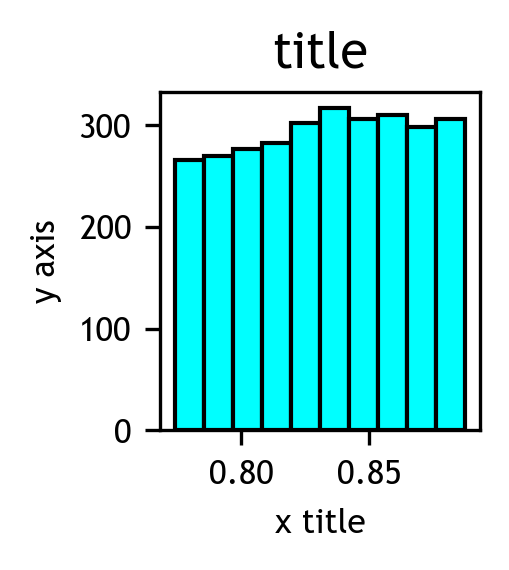

In [23]:
import utils.plot_utils
reload(utils.plot_utils)
from utils.plot_utils import make_plot


fig, axes, plot_inds = make_base_plot(plot_style, color_map, dpi, nrows, ncols, 
                   base=2, verbose=True, tight_layout = tight_layout)

data_from_plot, ax = make_plot(plot_params_here[plot_type], data_for_plot, 
                        axes[0], plot_type=plot_type, linestyles=linestyles_hist, 
                        rng=rng, 
                        barcolor='cyan', linecolor=(0,0,0), hasErr = False, lthick=1, nbins=10, rwidth=1.0)


title, xlabel, ylabel = add_titles_and_labels(axes[0], 'x title', 'y axis', 'title', 
                                              title_params, csfont, title_fontsize, 
                          xlabel_params, inlines, xlabel_ticks_fontsize, ylabel_ticks_fontsize,
                          rng=rng)

In [24]:
data_for_plot

{'xs': array([0.82055095, 0.82375684, 0.82172528, ..., 0.86056228, 0.87080305,
        0.83310381], shape=(2935,)),
 'ys': [],
 'xerrs': True,
 'data params': {'nsamples': 10000,
  'nclusters': 1,
  'centers': array([[0.85855147]]),
  'cluster_std': array([0.14265167]),
  'noise level': 0.1049343528642392}}

Loop for several distributions and save:

In [25]:
import utils.histogram_plot_qa_utils
reload(utils.histogram_plot_qa_utils)

from utils.histogram_plot_qa_utils import q_nbars_hist_plot_plotnums, q_stats_hists, q_gmm_ngaussians_hists

In [26]:
#plot_params_loop['histogram']['distribution']['gmm']

In [27]:
np.log10(1)

np.float64(0.0)

In [28]:

from utils.figure_gen_utils.pixel_location_utils import get_data_pixel_locations

def collect_plot_data_axes(ax, 
                           height, width,
                           data_from_plot, data_for_plot, plot_type, title, xlabel, ylabel,
                           distribution_type, verbose=False):
    """
    Collect the data from each plot.  Axes-level (per axis)

    ax : individual axes
    iplot : plot index
    """

    if ax.get_figure() is None:
        if verbose:
            print('[WARNING]: ax has no figure, using "fig"')
        ax.set_figure(fig)
    ###### get data from plot ######
    # data_from_plot = data_from_plots[iplot]
    # data_for_plot = data_for_plots[iplot]
    # plot_type = plot_types[iplot]
    # title = titles[iplot]
    # xlabel = xlabels[iplot]
    # ylabel = ylabels[iplot]
    ### JPN -- add back in char label
    # cbar_label = cbar_labels[iplot]
    # cbar_word = cbar_words[iplot]

    data_pixels = get_data_pixel_locations(data_from_plot, plot_type, ax, width, height)

    # bounding box of square
    bbox = ax.get_position() # Bbox(x0, y0, x1, y1)
    xpix1 = np.array([bbox.x0,bbox.x1])
    ypix1 = np.array([bbox.y0,bbox.y1])
    xpix1 *= width
    ypix1 *= height
        
    # x-tick locations
    try:
        xticks = get_ticks(ax, plot_type, 'x', fig=fig, verbose=verbose) # fig is not used for "regular" plots
    except Exception as e:
        if verbose:
            print('[ERROR]: issue getting x-ticks')
            print('  ', str(e))
        success_plot = False
        import sys; sys.exit()
        #continue

    # y-tick locations
    try:
        yticks = get_ticks(ax, plot_type, 'y', fig=fig, verbose=verbose)
    except Exception as e:
        if verbose:
            print('[ERROR]: issue getting y-ticks')
            print('  ', str(e))
            import sys; sys.exit()
        success_plot = False
        #continue
    
    #### JPN -- come back and add colorbars!
    # # for colorbars
    # colorbar_ticks = []
    # cbar_bbox = None; cbar_text = None
    # if 'color bar' in data_from_plot:
    #     colorbar = data_from_plot['color bar']
    #     if data_from_plot['color bar params']['side'] == 'left' \
    #         or data_from_plot['color bar params']['side'] == 'right':
    #         cbarax = 'y'
    #     else:
    #         cbarax = 'x'
    #     try:
    #         colorbar_ticks = get_ticks(colorbar, plot_type, cbarax, fig=fig, verbose=verbose)
    #     except Exception as e:
    #         if verbose:
    #             print('[ERROR]: issue getting colorbar ticks')
    #             print('  ', str(e))
    #             success_plot = False

        
    # Get the bounding box of the title in display space
    if title != '':
        title_bbox = title.get_window_extent()#dpi=dpi)
        title_words = title.get_text()
    else:
        title_bbox = -1
        title_words = ''

    # xlabel
    xlabel_bbox = xlabel.get_window_extent()#dpi=dpi)
    xlabel_words = xlabel.get_text()
    # ylabel
    ylabel_bbox = ylabel.get_window_extent()#dpi=dpi)
    ylabel_words = ylabel.get_text()

    # get offset text
    yoffset_text_obj = ax.yaxis.get_offset_text()
    yoffset_text = yoffset_text_obj.get_text()
    yoffset_text_bbox = None
    if yoffset_text != '':
        yoffset_text_bbox = yoffset_text_obj.get_window_extent()
    # also for x
    xoffset_text_obj = ax.xaxis.get_offset_text()
    xoffset_text = xoffset_text_obj.get_text()
    xoffset_text_bbox = None
    if xoffset_text != '':
        xoffset_text_bbox = xoffset_text_obj.get_window_extent()

    ####### SAVE THE DATA ######

    # line plot 
    #plot_name = 'plot' + str(iplot) 
    datas = {}
    # line plot type
    datas['type'] = plot_type # tag for kind of plot
    datas['distribution'] = distribution_type
    datas['data'] = data_for_plot
    if data_pixels != {}:
        datas['data pixels'] = data_pixels
    datas['data from plot'] = json.loads(json.dumps(data_from_plot, cls=NumpyEncoder))
    if (plot_type == 'scatter' or plot_type == 'contour' or plot_type == 'image of the sky') and 'color bar' in data_from_plot:
        #print('yes indeed')
        try:
            w = data_from_plot['color bar'].get_window_extent()#dpi=dpi)
        except:
            w = data_from_plot['color bar'].get_window_extent()
        datas['color bar'] = {'xmin':w.x0,'ymin':w.y0,
                                            'xmax':w.x1,'ymax':w.y1, 
                                            'params':data_from_plot['color bar params']}
        

        ##### JPN -- come back and add colorbars
        # # is it an image of the sky? (WCAxes)
        # if cbar_ax != []: # placeholder for no colorbar
        #     colorbar_label = None
        #     colorbar_offset_text = None
        #     if hasattr(cbar_ax, 'coords'):
        #         # have text
        #         for cbar_axc in cbar_ax.coords:
        #             if cbar_axc._axislabels.get_text() != '':
        #                 cbar_text = cbar_axc._axislabels.get_text()
        #                 cbar_bbox = cbar_axc._axislabels.get_window_extent()
        #                 colorbar_label = {'text':cbar_text, 
        #                                     'xmin':cbar_bbox.x0, 
        #                                     'ymin':cbar_bbox.y0,
        #                                     'xmax':cbar_bbox.x1,
        #                                     'ymax':cbar_bbox.y1}
        #                 print('colorbar_label is (WCAxes):', colorbar_label)
        #                 #print("HAVE TO CHECK FOR OFFSET TEXT")
        #                 #import sys; sys.exit()
        #         # try this
        #         yoff = cbar_ax.yaxis.get_offset_text() #get_text()
        #         xoff = cbar_ax.yaxis.get_offset_text()
        #         if xoff.get_text() != '' and yoff.get_text() != '':
        #             print('both x & y have offset text and I dont know how to deal!')
        #             import sys; sys.exit()
        #         elif xoff.get_text() != '':
        #             cbar_offset_text = xoff
        #         else:
        #             cbar_offset_text = yoff # either something or nothing
        #         if cbar_offset_text.get_text() != '':
        #             cbar_ot_bb = cbar_offset_text.get_window_extent()
        #             colorbar_offset_text = {'text':cbar_offset_text.get_text(), 
        #                                     'xmin':cbar_ot_bb.x0, 
        #                                     'ymin':cbar_ot_bb.y0,
        #                                     'xmax':cbar_ot_bb.x1,
        #                                     'ymax':cbar_ot_bb.y1}
        #     elif hasattr(cbar_ax, '_colorbar'):
        #         # check both x & y
        #         if cbar_ax.yaxis.label.get_text() != '':
        #             cbar_text = cbar_ax.yaxis.label.get_text()
        #             cbar_bbox = cbar_ax.yaxis.label.get_window_extent()
        #             cbar_offset_text = cbar_ax.yaxis.get_offset_text()
        #         elif cbar_ax.xaxis.label.get_text() != '':
        #             cbar_text = cbar_ax.xaxis.label.get_text()
        #             cbar_bbox = cbar_ax.xaxis.label.get_window_extent()
        #             cbar_offset_text = cbar_ax.xaxis.get_offset_text()
        #         else:
        #             print('no label for colorbar!')
        #             cbar_text = ''
        #             cbar_offset_text = cbar_ax.xaxis.get_offset_text() # placeholder
        #         # cbar_text = cbar_ax.get_ylabel()
        #         # cbar_bbox = cbar_ax.get_window_extent()
        #         if cbar_text != '':
        #             colorbar_label = {'text':cbar_text, 
        #                                     'xmin':cbar_bbox.x0, 
        #                                     'ymin':cbar_bbox.y0,
        #                                     'xmax':cbar_bbox.x1,
        #                                     'ymax':cbar_bbox.y1}
        #             print('colorbar_label is (matplotlib):', colorbar_label)
        #         #import sys; sys.exit()
        #         if cbar_offset_text.get_text() != '':
        #             cbar_ot_bb = cbar_offset_text.get_window_extent()
        #             colorbar_offset_text = {'text':cbar_offset_text.get_text(), 
        #                                     'xmin':cbar_ot_bb.x0, 
        #                                     'ymin':cbar_ot_bb.y0,
        #                                     'xmax':cbar_ot_bb.x1,
        #                                     'ymax':cbar_ot_bb.y1}
        #     else:
        #         print('not sure what kind of colorbar this is!')
        #         import sys; sys.exit()

        #     if colorbar_label is None:
        #         print('colorbar_label is None for iplot =', iplot, '!')
        #         #import sys; sys.exit()
        #     else:
        #         datas['color bar']['label'] = colorbar_label.copy()

        #     if colorbar_offset_text is None:
        #         pass
        #     else:
        #         datas['color bar']['offset text'] = colorbar_offset_text.copy()

    xtmp = []
    for xt in xticks:
        l = {'data':xt[0], 'xmin': xt[1], 
                'ymin': xt[2], 
                'xmax':xt[3], 'ymax':xt[4],
                'tx':xt[5], 'ty':xt[6]}
        xtmp.append(l)
    datas['xticks'] = xtmp.copy()
    # 
    xtmp = []
    for xt in yticks:
        l = {'data':xt[0], 'xmin': xt[1], 
                'ymin': xt[2], 
                'xmax':xt[3], 'ymax':xt[4], 
            'tx':xt[5], 'ty':xt[6]}
        xtmp.append(l)
    datas['yticks'] = xtmp.copy()
    ##### JPN -- come back for colorbars
    # if len(colorbar_ticks) > 0:
    #     xtmp = []
    #     for xt in colorbar_ticks:
    #         l = {'data':xt[0], 'xmin': xt[1], 
    #                 'ymin': xt[2], 
    #                 'xmax':xt[3], 'ymax':xt[4], 
    #             'tx':xt[5], 'ty':xt[6]}
    #         xtmp.append(l)
    #     datas['color bar ticks'] = xtmp.copy()
        
    # axis box
    datas['square'] = {'xmin':xpix1[0], 'ymin':ypix1[0], 
                                        'xmax':xpix1[1], 'ymax':ypix1[1]}
    # title
    if title_bbox != -1:
        datas['title'] = {'xmin':title_bbox.x0, 'ymin':title_bbox.y0, 
                                        'xmax':title_bbox.x1, 'ymax':title_bbox.y1,
                                        'words':title_words}
    else:
        pass
    datas['xlabel'] = {'xmin':xlabel_bbox.x0, 'ymin':xlabel_bbox.y0, 
                                    'xmax':xlabel_bbox.x1, 'ymax':xlabel_bbox.y1,
                                    'words':xlabel_words}
    datas['ylabel'] = {'xmin':ylabel_bbox.x0, 'ymin':ylabel_bbox.y0, 
                                    'xmax':ylabel_bbox.x1, 'ymax':ylabel_bbox.y1,
                                    'words':ylabel_words}
    # offset text
    for lt,lbb,t in zip([xoffset_text,yoffset_text],
                        [xoffset_text_bbox,yoffset_text_bbox], ['x','y']):
        if lt != '': # have something
            datas[t + '-offset text'] = {'xmin':lbb.x0, 
                                                    'ymin':lbb.y0, 
                                    'xmax':lbb.x1, 'ymax':lbb.y1,
                                    'words':lt}
            
    return datas

In [29]:
def init_qa_pairs():
    """
    Set format for qa pairs part of JSON
    """
    # create qa pairs
    qa_pairs = {}
    # question levels    
    qa_pairs['Level 1'] = {}
    qa_pairs['Level 2'] = {}
    qa_pairs['Level 3'] = {}
    qa_pairs['Level 1']['Figure-level questions'] = {} # Figure-level questions
    qa_pairs['Level 1']['Plot-level questions'] = {}
    qa_pairs['Level 2']['Plot-level questions'] = {}
    qa_pairs['Level 3']['Plot-level questions'] = {}
    return qa_pairs

QUESTION: You are a helpful assistant that can analyze images.  How many bars are there in the specified figure panel? Please format the output as a json as {"nbars":""} for this figure panel, where the "nbars" value should be an integer.
ANSWER: {'nbars ': 50}
QUESTION: You are a helpful assistant that can analyze images.  What are the minimum data values in this figure panel?  Please format the output as a json as {"minimum x":""} for this figure panel, where the "minimum" value should be a float, calculated from the data values used to create the plot.
ANSWER: {'minimum ': {'plot0': {'minimum x': np.float64(0.7386071169423961)}}}
QUESTION: You are a helpful assistant that can analyze images.  What are the maximum data values in this figure panel?  Please format the output as a json as {"maximum x":""} for this figure panel, where the "maximum" value should be a float, calculated from the data values used to create the plot.
ANSWER: {'maximum ': {'plot0': {'maximum x': np.float64(0.7

<Figure size 640x480 with 0 Axes>

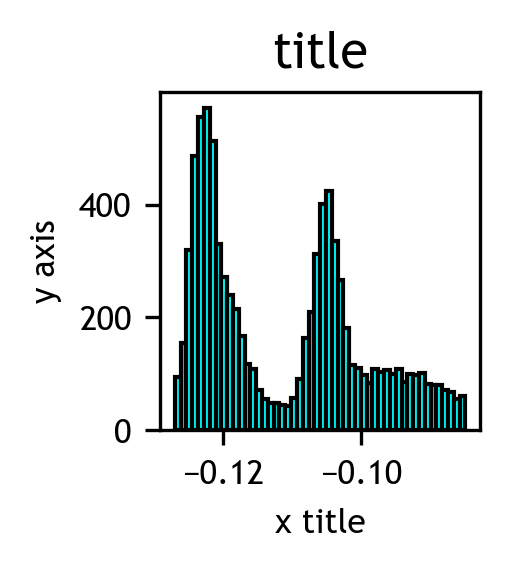

In [30]:
reload(utils.histogram_plot_qa_utils)
from utils.histogram_plot_qa_utils import q_nbars_hist_plot_plotnums, q_stats_hists, q_gmm_ngaussians_hists


nclusters = [1, 2, 3, 4, 5]

cluster_std = {'min':-2, 'max':0.0} # in 10^

noise = {'min': 0.05, 'max': 0.1}

plot_json = []

ntrials = 10

verbose_qa = True

# check for github
if 'LLM_VQA_JCDL2025' in fake_figs_dir and ntrials > 10:
    print('Limiting trials for saving in github.  Change the "fake_figs_dir" param to a local address')
    ntrials = 10

for n in range(ntrials):
    for nclust in nclusters:

        # this becomes more important when we have multiple axes and more complex plots
        data_for_plots = []
        plot_types = []
        data_from_plots = []
        titles = []; xlabels = []; ylabels = []; 
        cbars = []; cbar_labels = []; cbar_words = []; cbar_nums = []
        end_time = time.time()
        distribution_types = []
        # in case axes change
        axes_save = []; cbar_axes_save = []

        plot_params_loop = plot_params_here.copy()
        plot_params_loop['histogram']['distribution']['gmm']['nclusters'] = {'min': nclust, 'max': nclust}
        plot_params_loop['histogram']['distribution']['gmm']['cluster std'] = cluster_std
        plot_params_loop['histogram']['distribution']['gmm']['noise'] = noise
        data_for_plot = get_data(plot_params_loop[plot_type],
                        plot_type=plot_type,
                                distribution=distribution_type, 
                                rng=rng)
        # pltjson = {}
        # pltjson['nclusters'] = nclust
        # pltjson['data for plot'] = data_for_plot.copy()

        fig, axes, plot_inds = make_base_plot(plot_style, color_map, dpi, nrows, ncols, 
                    base=2, verbose=False, tight_layout = tight_layout)

        for iplot, ax in enumerate(axes):
            data_from_plot, ax = make_plot(plot_params_loop[plot_type], data_for_plot, 
                                    ax, plot_type=plot_type, linestyles=linestyles_hist, 
                                    rng=rng, 
                                    barcolor='cyan', linecolor=(0,0,0), hasErr = False, lthick=1, nbins=50, rwidth=1.0)
            #pltjson['data from plot'] = data_from_plot.copy()

            # add title/x/y labels
            title, xlabel, ylabel = add_titles_and_labels(ax, 'x title', 'y axis', 'title', 
                                                title_params, csfont, title_fontsize, 
                            xlabel_params, inlines, xlabel_ticks_fontsize, ylabel_ticks_fontsize,
                            rng=rng)

            # save image
            base_name = 'nclust_' + str(nclust) + '_trial' + str(n)
            for imgf in img_format:
                fig.savefig(img_dir + base_name + '.' + imgf)

            ####### SAVE DATA ########
            # save data for parsing later -- only a single plot right now
            data_for_plots.append(data_for_plot)
            plot_types.append(plot_type)
            data_from_plots.append(data_from_plot)
            titles.append(title)
            xlabels.append(xlabel)
            ylabels.append(ylabel)
            distribution_types.append(distribution_type)

        fig.canvas.draw()
        width, height = fig.canvas.get_width_height()
        # save data
        datas = {}
        # figure datas
        datas['figure'] = {'dpi':dpi, 'base':base, 'aspect ratio': aspect_fig, 
                            'nrows':nrows, 'ncols':ncols, 
                            'plot style':plot_style, 
                            'color map':color_map,
                            'title fontsize':title_fontsize, 
                            'xlabel fontsize':xlabel_fontsize,
                            'ylabel fontsize':ylabel_fontsize, 
                        'plot indexes':plot_inds}
        for iplot,ax in enumerate(axes): ### JPN, colorbar
            datas['plot' + str(iplot)] = collect_plot_data_axes(ax, 
                           height, width,
                           data_from_plots[iplot], data_for_plots[iplot], 
                           plot_types[iplot], titles[iplot], 
                           xlabels[iplot], ylabels[iplot],
                           distribution_types[iplot], verbose=True)
            

        ######## GENERATE QA BASE #######
        qa_pairs = init_qa_pairs()
        for iplot in range(len((axes))):
            if datas['plot'+str(iplot)]['type'] == 'histogram':
                ############ L1 #############
                # number of bars
                if len(axes) > 1:
                    qa_pairs = q_nbars_hist_plot_plotnums(datas, qa_pairs, plot_num = iplot, use_words=False, verbose=verbose_qa)
                qa_pairs = q_nbars_hist_plot_plotnums(datas, qa_pairs, plot_num = iplot, use_words=True, verbose=verbose_qa)

                ###### L2 #######
                # stats items
                for k,v in stats.items():
                    if len(axes) > 1:
                        qa_pairs = q_stats_hists(datas, qa_pairs, stat={k:v}, plot_num=iplot, use_words=False, verbose=verbose_qa)
                    qa_pairs = q_stats_hists(datas, qa_pairs, stat={k:v}, plot_num=iplot, use_words=True, verbose=verbose_qa)

                ###### L3 ######
                # if GMM -- how many gaussians?
                hasGMM = False
                if 'data params' not in datas['plot'+str(iplot)]['data']:
                    #print('Not a gmm relationship!')
                    pass
                else:
                    if datas['plot'+str(iplot)]['distribution'] == 'gmm':
                        hasGMM = True
                if hasGMM:       
                    qa_pairs = q_gmm_ngaussians_hists(datas, qa_pairs, plot_num=iplot, use_words=True, verbose=verbose_qa)

        datas['VQA'] = qa_pairs


        #import sys; sys.exit()

        # dump full data
        dumped = json.dumps(datas, cls=NumpyEncoder)
        with open(json_dir + base_name + '.json', 'w') as f:
            json.dump(dumped, f)

        #plot_json.append(pltjson.copy())

In [54]:
#datas['VQA']

In [55]:
#datas['VQA']['Level 1']['Plot-level questions']

Practice reading in:

In [65]:
import json
data_file = json_dir + 'nclust_4_trial8.json'
with open(data_file,'r') as f:
    t = json.load(f)
    datas = json.loads(t)

In [38]:
datas['VQA']

{'Level 1': {'Figure-level questions': {},
  'Plot-level questions': {'nbars ': {'plot0': {'Q': 'You are a helpful assistant that can analyze images.  How many bars are there in the specified figure panel? Please format the output as a json as {"nbars":""} for this figure panel, where the "nbars" value should be an integer.',
     'A': {'nbars ': 50},
     'persona': 'You are a helpful assistant that can analyze images.',
     'context': '',
     'question': 'How many bars are there in the specified figure panel?',
     'format': 'Please format the output as a json as {"nbars":""} for this figure panel, where the "nbars" value should be an integer.'}}}},
 'Level 2': {'Plot-level questions': {'minimum ': {'plot0': {'Q': 'You are a helpful assistant that can analyze images.  What are the minimum data values in this figure panel?  Please format the output as a json as {"minimum x":""} for this figure panel, where the "minimum" value should be a float, calculated from the data values used 

In [66]:
datas['VQA']['Level 1']['Plot-level questions']

{'nbars ': {'plot0': {'Q': 'You are a helpful assistant that can analyze images.  How many bars are there in the specified figure panel? Please format the output as a json as {"nbars":""} for this figure panel, where the "nbars" value should be an integer.',
   'A': {'nbars ': 50},
   'persona': 'You are a helpful assistant that can analyze images.',
   'context': '',
   'question': 'How many bars are there in the specified figure panel?',
   'format': 'Please format the output as a json as {"nbars":""} for this figure panel, where the "nbars" value should be an integer.'}}}